**Test File**

Check the histogram of the raw DICOM images to check for ringing.

In [ ]:
import pydicom as dicom
import matplotlib.pylab as plt

# specify your image path
time_point_one_image_path = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/original_dicom/B-RAP_0100_01_D1/12/DICOM'
ds = dicom.dcmread(time_point_one_image_path)

plt.imshow(ds.pixel_array)

In [1]:
import os
from pathlib import Path
import pydicom

dir_path = r'/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/original_dicom/B-RAP_0100_01_D1/12/DICOM'

dicom_set = []
for root, _, filenames in os.walk(dir_path):
    for filename in filenames:
        dcm_path = Path(root, filename)
        if dcm_path.suffix == ".dcm":
            try:
                dicom = pydicom.dcmread(dcm_path, force=True)
            except IOError as e:
                print(f"Can't import {dcm_path.stem}")
            else:
                dicom_set.append(dicom)

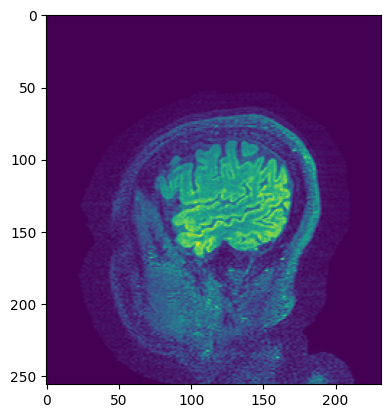

In [2]:
import matplotlib.pylab as plt
plt.imshow(dicom_set[0].pixel_array)

Used FSL plot instead for investigation.

Apply mask from FSL BET to earlier time point to assess whether the artefacts are still similar as HD-BET.

In [5]:
import numpy as np
import os
import pandas as pd
import shutil
import nipype.interfaces.fsl as fsl

nifti_file_format = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/original_nifti/B-RAP_0100_01_D1.nii.gz'
brain_file_mask_format = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti/time_point_2_tests/robust_brain_centre/f_40/B-RAP_0100_02_D1_mask.nii.gz'
brain_file_format = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti/time_point_2_tests/robust_brain_centre/f_40/B-RAP_0100_01_D1.nii.gz' 

# need to register the two time points using rigid registration
extracted_brain = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti/time_point_2_tests/robust_brain_centre/f_40/B-RAP_0100_02_D1.nii.gz'
brain_to_extract = nifti_file_format
mask = brain_file_mask_format

# create folder for registered images if they don't exist (contains all time points registered to the final point)
registered_whole_brain = '/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti/time_point_2_tests/robust_brain_centre/f_40/B-RAP_0100_01_D1_to_02.nii.gz' 

temporal_flt = fsl.FLIRT(
                    cost_func = 'mutualinfo', # inconsistent intensities 
                    dof = 6, # rigid body transformation
                    interp = 'trilinear')
temporal_flt.inputs.in_file = brain_to_extract
temporal_flt.inputs.reference = extracted_brain
temporal_flt.inputs.output_type = "NIFTI_GZ" # save as a NIFTI file
temporal_flt.inputs.out_file = registered_whole_brain
temporal_flt_result= temporal_flt.run() 
print('Registered time points ')


apply_mask_BET = fsl.ApplyMask()
apply_mask_BET.inputs.in_file = registered_whole_brain
apply_mask_BET.inputs.mask_file = mask
apply_mask_BET.inputs.out_file = brain_file_format
FLAIR_bet_res = apply_mask_BET.run()
print('Extracted 3D-FLAIR brain at time point')

TraitError: The 'in_file' trait of a FLIRTInputSpec instance must be a pathlike object or string representing an existing file, but a value of '~/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/original_nifti/B-RAP_0100_01_D1.nii.gz' <class 'str'> was specified.

# Cleaning up Bias Field Correction

In [16]:
import shutil
import os

source_folder = "/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/brain_nifti"
target_folder = "/home/ela/Documents/B-RAPIDD/B-RAP_0100/3D-FLAIR/bias_nifti"
bias_subfolder = os.path.join(target_folder, "fields")

# Create the target directories if they don't exist
#os.makedirs(target_folder, exist_ok=True)
#os.makedirs(target_subfolder, exist_ok=True)

# Iterate over the files in the source folder
for filename in os.listdir(source_folder):
    if filename.startswith("B-RAP_0100"):
        base_name = filename.rsplit(".", 2)[0]  # Remove the file extension
        suffix = base_name.rsplit("_", 1)[1]  # Get the last part of the base name
        #print(suffix)
        # Check if the file is 'restore' or 'bias' and move it accordingly
        if suffix == "restore":
            target_path = os.path.join(target_folder, filename)
            shutil.move(os.path.join(source_folder, filename), target_path)
        elif suffix == "bias":
            target_path = os.path.join(bias_subfolder, filename)
            shutil.move(os.path.join(source_folder, filename), target_path)
        # delete files that are unneccessary
        elif suffix == "mixeltype":
            os.remove(os.path.join(source_folder, filename))
        elif suffix == "seg":
            os.remove(os.path.join(source_folder, filename))
        elif "pve" in base_name:
            os.remove(os.path.join(source_folder, filename))
        else:
            continue  # Skip files with other suffixes
    